In [1]:
!pip install ete3
!pip install Bio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 28.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ete3: filename=ete3-3.1.3-py3-none-any.whl size=2273786 sha256=f0cc0e5d2489e4e7dc6c96f51ca79a47229db134c8103c1e4ea17ae10bdfaf1e
  Stored in directory: /root/.cache/pip/wheels/dd/a8/60/0a29caa9f8ceb7316704be63c1578ab13c36668abb646366ac
Successfully built ete3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.3 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from io import StringIO
from ete3 import Tree
from Bio import Phylo
import io
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform

import pandas as pd
from ete3 import Tree
from typing import Dict, List, Tuple
from matplotlib.patches import Patch
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import os
os.chdir("drive/MyDrive/Colab_Notebooks/New_ideas")

In [5]:
os.makedirs("data_correlation", exist_ok=True)

In [6]:
def df_to_newick(df):
    from collections import defaultdict

    def insert_path(tree, path):
        for node in path:
            tree = tree.setdefault(node, {})
        return tree

    def to_newick(tree):
        if not tree:
            return ""
        children = []
        for node, subtree in tree.items():
            child_str = to_newick(subtree)
            if child_str:
                children.append(f"({child_str}){node}")
            else:
                children.append(f"{node}")
        return ",".join(children)

    # Build a nested tree (dictionary)
    tree = {}
    for path in df.values.tolist():
        insert_path(tree, path)

    return to_newick(tree) + ';'

def add_one_to_branch_lengths_biopy(newick: str) -> str:
    """
    Parse the Newick with Biopython, add 1.0 to all branch lengths,
    and return the modified Newick string.
    """
    # Read from string
    handle = StringIO(newick)
    tree = Phylo.read(handle, "newick")

    # Add 1.0 to each branch length
    for clade in tree.find_clades():
        if clade.branch_length is None:
            clade.branch_length = 1.0

    # Write back out as Newick
    out_handle = StringIO()
    Phylo.write(tree, out_handle, "newick")
    return out_handle.getvalue().strip()

#1. Simple Correlation Heatmap with Seaborn


1.1 Explanation
A correlation heatmap displays the correlation coefficients between all pairs of numeric variables in a matrix form, with colors indicating strength and direction.We focus on bacteria correlation, and we assume that the bacteria abundance are already processed, e.g, filter of low abundant species, clr transformation.

1.2 Code Example

In [10]:

np.random.seed(0)
cols1 = [f"Genus_{i}" for i in range(1,21)]
cols2 = [f"Genus_{i}" for i in range(10,31)]
df1 = pd.DataFrame(np.random.rand(100, len(cols1)), columns=cols1)
df2 = pd.DataFrame(np.random.rand(100, len(cols2)), columns=cols2)

Compute the spearman correlation

In [11]:
corr1 = df1.corr()
corr2 = df2.corr()

Dataframe overview

In [12]:
df1.head()

,Genus_1,Genus_2,Genus_3,Genus_4,Genus_5,Genus_6,Genus_7,Genus_8,Genus_9,Genus_10,Genus_11,Genus_12,Genus_13,Genus_14,Genus_15,Genus_16,Genus_17,Genus_18,Genus_19,Genus_20
0,0.548814,0.715189,0.602763,0.544883,0.423655,0.645894,0.437587,0.891773,0.963663,0.383442,0.791725,0.528895,0.568045,0.925597,0.071036,0.087129,0.020218,0.832620,0.778157,0.870012
1,0.978618,0.799159,0.461479,0.780529,0.118274,0.639921,0.143353,0.944669,0.521848,0.414662,0.264556,0.774234,0.456150,0.568434,0.018790,0.617635,0.612096,0.616934,0.943748,0.681820
2,0.359508,0.437032,0.697631,0.060225,0.666767,0.670638,0.210383,0.128926,0.315428,0.363711,0.570197,0.438602,0.988374,0.102045,0.208877,0.161310,0.653108,0.253292,0.466311,0.244426
3,0.158970,0.110375,0.656330,0.138183,0.196582,0.368725,0.820993,0.097101,0.837945,0.096098,0.976459,0.468651,0.976761,0.604846,0.739264,0.039188,0.282807,0.120197,0.296140,0.118728
4,0.317983,0.414263,0.064147,0.692472,0.566601,0.265389,0.523248,0.093941,0.575946,0.929296,0.318569,0.667410,0.131798,0.716327,0.289406,0.183191,0.586513,0.020108,0.828940,0.004695


Plot the correlation of the first dataset as overview

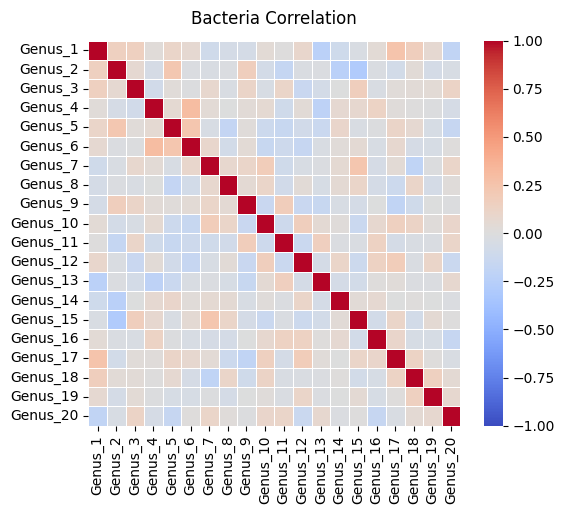

In [13]:
corr = df1.corr()
plt.figure(figsize=(6,5))
sns.heatmap(
    corr,
    annot=False, fmt=".2f",
    vmin=-1, vmax=1,
    cmap="coolwarm",
    linewidths=0.5
)
plt.title("Bacteria Correlation", pad=12)
plt.show()

Add the legend below

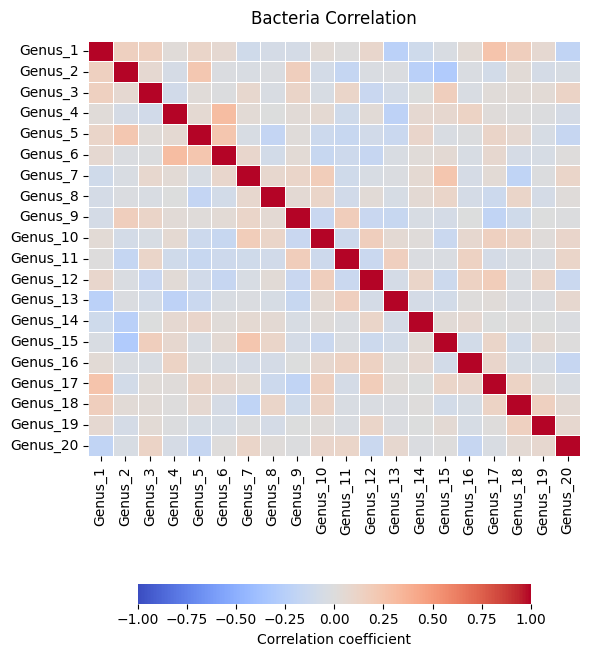

In [40]:
plt.figure(figsize=(6,7))
ax = sns.heatmap(
    corr,
    annot=False, fmt=".2f",
    vmin=-1, vmax=1,
    cmap="coolwarm",
    linewidths=0.5,
    cbar=True,
    cbar_kws={
        'orientation': 'horizontal',
        'label': 'Correlation coefficient',
        'pad': 0.2,            # space between plot and colorbar
        'shrink': 0.8          # adjust length of the colorbar
    }
)
plt.title("Bacteria Correlation", pad=12)
plt.tight_layout()
plt.show()

Change the color

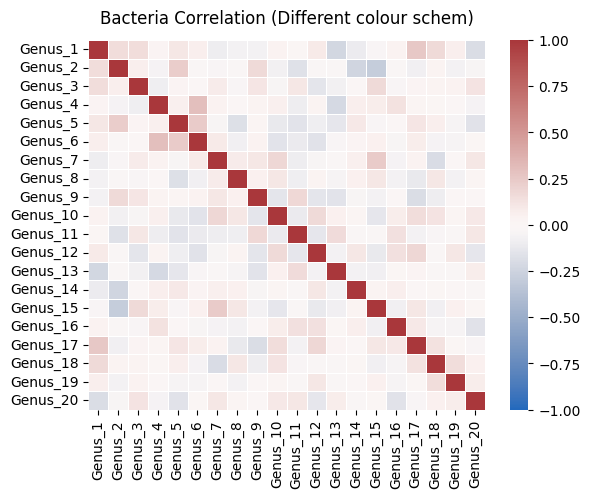

In [35]:
sns.heatmap(
    corr,
    annot=False, fmt=".2f",
    vmin=-1, vmax=1,
    cmap="vlag",
    linewidths=0.5
)
plt.title("Bacteria Correlation (Different colour schem)", pad=12)
plt.show()

# 2. Hierarchical clustering of the heatmap

We can cluster the heatmap using different distance measure, and clustering algorithm with the "clustermap" function. Here we use euclidean distance, and average method for clustering.

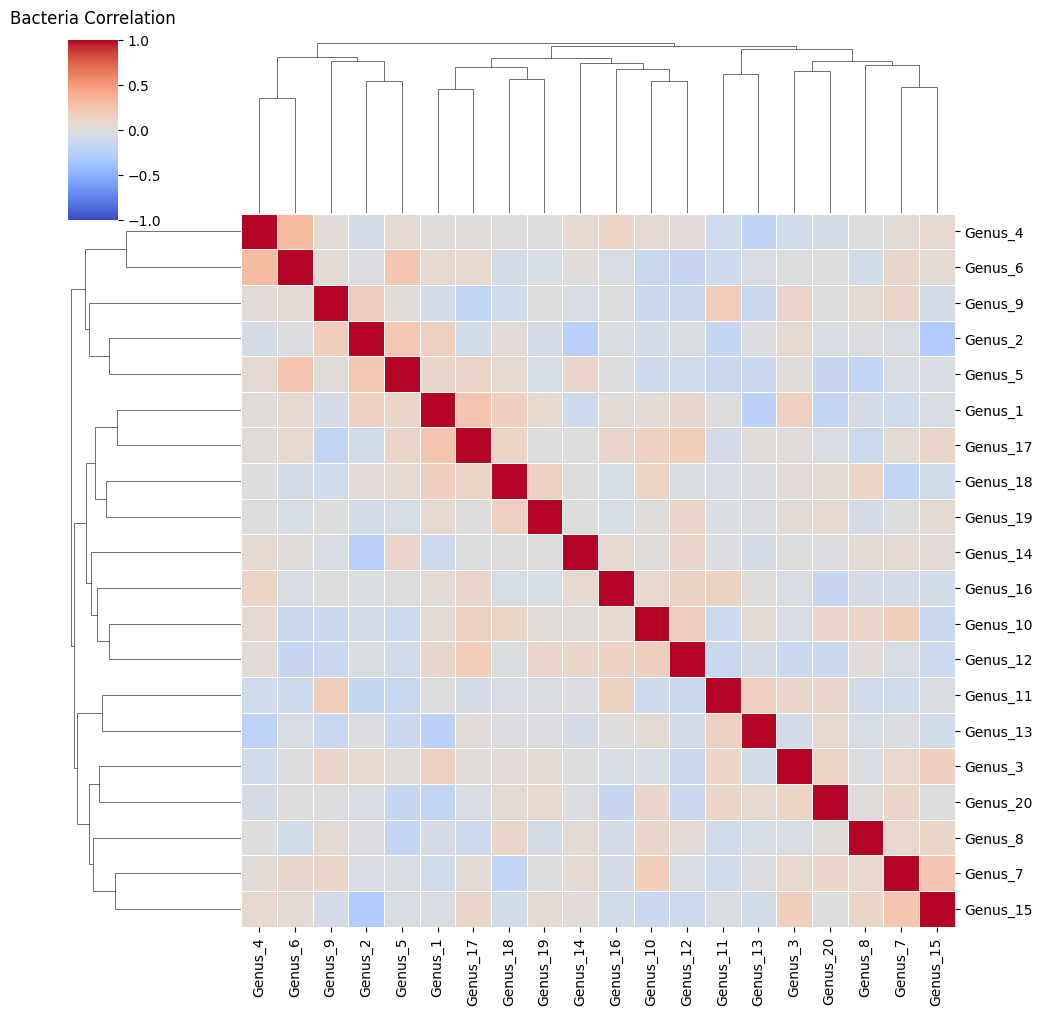

In [36]:
sns.clustermap(
    corr,
    annot=False, fmt=".2f",
    vmin=-1, vmax=1,
    cmap="coolwarm",
    linewidths=0.5,
    method='average', metric='euclidean'
)
plt.title("Bacteria Correlation", pad=12)
plt.show()

# 3. compare the 2 correlations

In the first approach, we select the intersection of the columns.

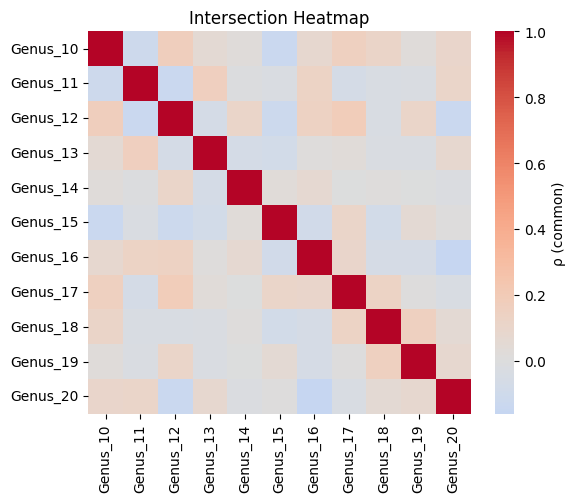

In [14]:
# Plot of the first dataset
common = corr1.columns.intersection(corr2.columns)
c1_int = corr1.loc[common, common]
c2_int = corr2.loc[common, common]

# Plot
plt.figure(figsize=(6,5), dpi=100)
sns.heatmap(c1_int, cmap="coolwarm", center=0, square=True,
            cbar_kws={'label':'ρ (common)'}).set_title("Intersection Heatmap")
plt.tight_layout()

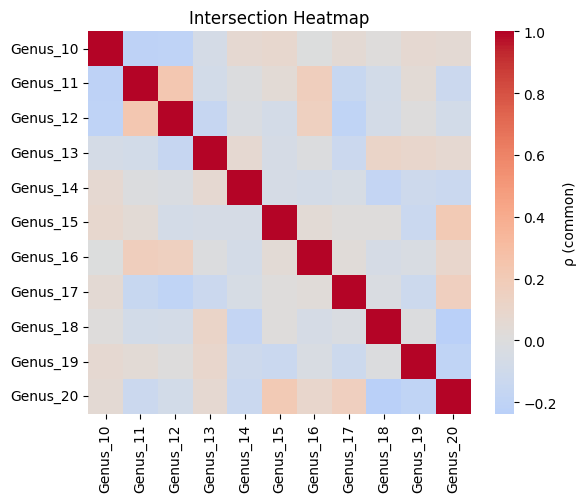

In [15]:
# Correlation of the intersection of the second dataset
plt.figure(figsize=(6,5), dpi=100)
sns.heatmap(c2_int, cmap="coolwarm", center=0, square=True,
            cbar_kws={'label':'ρ (common)'}).set_title("Intersection Heatmap")
plt.tight_layout()

# 4. Union over the columns
We can plot the two correlations on the union of the two taxa, with the correlations associated to the non-present taxa in grey.

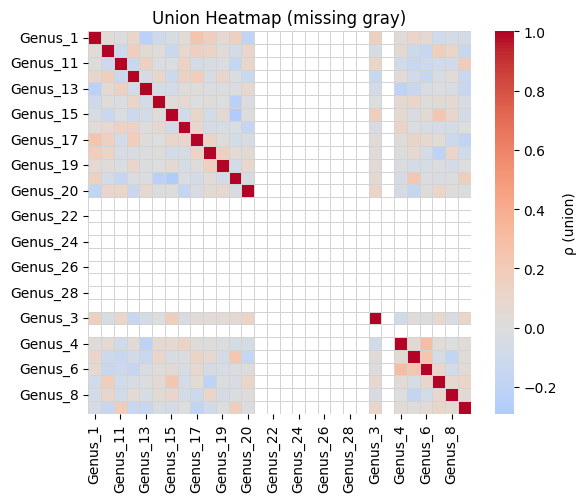

In [16]:
all_taxa = corr1.columns.union(corr2.columns)
c1_union = corr1.reindex(index=all_taxa, columns=all_taxa)
c2_union = corr2.reindex(index=all_taxa, columns=all_taxa)
mask1 = c1_union.isna()

plt.figure(figsize=(6,5), dpi=100)
sns.heatmap(c1_union, cmap="coolwarm", center=0, mask=mask1,
            square=True, cbar_kws={'label':'ρ (union)'},
            linewidths=0.5, linecolor="lightgray")
plt.title("Union Heatmap (missing gray)")
plt.tight_layout()

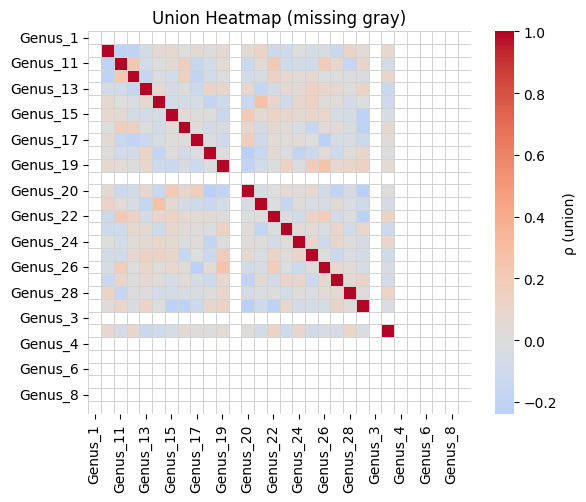

In [ ]:
mask2 = c2_union.isna()

plt.figure(figsize=(6,5), dpi=100)
sns.heatmap(c2_union, cmap="coolwarm", center=0, mask=mask2,
            square=True, cbar_kws={'label':'ρ (union)'},
            linewidths=0.5, linecolor="lightgray")
plt.title("Union Heatmap (missing gray)")
plt.tight_layout()

# 5. Taxonomy information
In many cases in microbiome analysis we also have taxonomy information over the bacteria, where bacteria abundance can be aggregated at different hierarchical levels. Here we shouw the correlation of the bacteria at the genus level, ordered based on a taxonomic tree. First we construct the hierarchical tree (that is usually given). (Different from clustermap, here the hierarchy is NOT based on the data!).

In [17]:
taxonomy = pd.DataFrame({
    'Genus': all_taxa,
    'Family': [f"Fam_{i%5}" for i in range(len(all_taxa))],
    'Order' : [f"Ord_{i%3}" for i in range(len(all_taxa))],
    "Phylum" : [f"Phy_{i%1}" for i in range(len(all_taxa))]
})

In [18]:
for i in ["Fam_0", "Fam_1", "Fam_2"]:
  index1 = taxonomy[taxonomy["Family"]==i].index
  taxonomy.loc[index1,"Order"] = "Ord1"

for j in ["Fam_3", "Fam_4"]:
  index2 = taxonomy[taxonomy["Family"]==j].index
  taxonomy.loc[index2,"Order"] = "Ord2"


In [19]:
taxonomy.loc[23] = ["Genus_30", "Fam_5", "Ord3", "Phy_0"]

In [20]:
taxonomy.head()

,Genus,Family,Order,Phylum
0,Genus_1,Fam_0,Ord1,Phy_0
1,Genus_10,Fam_1,Ord1,Phy_0
2,Genus_11,Fam_2,Ord1,Phy_0
3,Genus_12,Fam_3,Ord2,Phy_0
4,Genus_13,Fam_4,Ord2,Phy_0


# 6. Plot the correlations ordered based on the Taxonomy

Here we want to use the hieararchical information in plotting the taxa correlation ordered based on the hierarchical structure of each taxa.

# 7. Intersection Hierarchy

In [27]:
taxonomy_intersection = taxonomy.copy()
taxonomy_intersection.index = taxonomy["Genus"]
taxonomy_intersection = taxonomy_intersection.loc[common]
taxonomy_intersection.reset_index(inplace=True)

In [28]:
taxonomy_intersection.head()

,index,Genus,Family,Order,Phylum
0,Genus_10,Genus_10,Fam_1,Ord1,Phy_0
1,Genus_11,Genus_11,Fam_2,Ord1,Phy_0
2,Genus_12,Genus_12,Fam_3,Ord2,Phy_0
3,Genus_13,Genus_13,Fam_4,Ord2,Phy_0
4,Genus_14,Genus_14,Fam_0,Ord1,Phy_0


In [29]:
nwk_format_intersection = df_to_newick(taxonomy_intersection.loc[:,['Phylum','Order','Family', "Genus"]])

Newick format

In [30]:
nwk_format_intersection

'(((Genus_10,Genus_15)Fam_1,(Genus_11,Genus_16,Genus_20)Fam_2,(Genus_14,Genus_19)Fam_0)Ord1,((Genus_12,Genus_17)Fam_3,(Genus_13,Genus_18)Fam_4)Ord2)Phy_0;'

In [31]:
tree_intersection = Tree(nwk_format_intersection, format=1)
leaf_order_interesction = [leaf.name for leaf in tree_intersection.iter_leaves()]
c_intersection_tax = c2_int.loc[leaf_order_interesction, leaf_order_interesction]

nwk_format_intersection1 = add_one_to_branch_lengths_biopy(nwk_format_intersection)

In [33]:
tree_intersection2 = Phylo.read(StringIO(nwk_format_intersection1), "newick")

# 3. Extract leaf names in the order they appear
leaves = [t.name for t in tree_intersection2.get_terminals()]

# 4. Compute the full pairwise‐distance matrix from the tree
dm_int = pd.DataFrame(
    [[tree_intersection2.distance(i, j) for j in leaves] for i in leaves],
    index=leaves,
    columns=leaves,
    dtype=float
)

# 5. Condense to a 1D array and run UPGMA (average‐linkage) to recover the same hierarchy
condensed = squareform(dm_int.values)
linkage_matrix = linkage(condensed, method="average")

# 6. Reindex your data to match the leaf order
#    (assuming code_df’s index and columns are named by the same leaf IDs)
df_ordered_int1 = c2_int.loc[leaves, leaves]


/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)
/tmp/ipython-input-34-1057240753.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  g.ax_heatmap.legend(


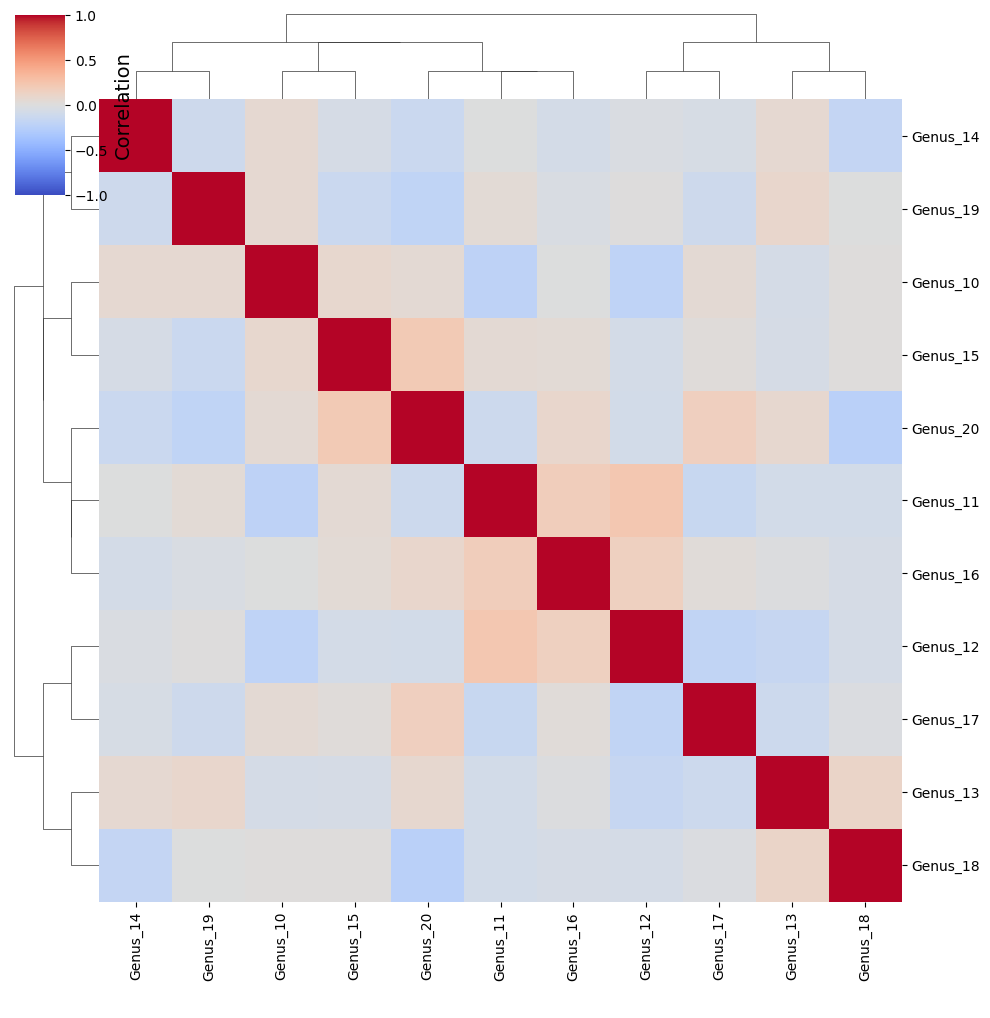

In [34]:
# 7. Plot with exactly that linkage
g = sns.clustermap(
    df_ordered_int1,
    cmap='coolwarm',
    vmin = -1,
    vmax = 1,
    row_linkage=linkage_matrix,
    col_linkage=linkage_matrix,
    row_cluster=True,
    col_cluster=True,
    dendrogram_ratio=(0.1, 0.1),
    square=True,
    linewidths=0.0,
    linecolor="gray",
    xticklabels=True,
    yticklabels=True,
    cbar_kws={
          'label': 'Correlation',
          'shrink': 0.7,
          'orientation': 'vertical'
      },
)


g.ax_heatmap.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.15),  # push further down if needed
    ncol=4,
    frameon=False,
    handlelength=2,
    handleheight=2,
    handletextpad=2,
    columnspacing=2.0,
    fontsize=20,
)

# 8. Fix colorbar labels

# Save the figure
g.ax_cbar.set_ylabel("Correlation", fontsize=14)
plt.show()

# 8. Union hierarchy

We now plot the correlation based on the hierarchy for the union of the two datasets.

We transform the dataset in newick format

In [ ]:
nwk_format = df_to_newick(taxonomy.loc[:,['Phylum','Order','Family', "Genus"]])

In [ ]:
nwk_format

'(((Genus_1,Genus_14,Genus_19,Genus_23,Genus_28,Genus_5)Fam_0,(Genus_10,Genus_15,Genus_2,Genus_24,Genus_29,Genus_6)Fam_1,(Genus_11,Genus_16,Genus_20,Genus_25,Genus_3,Genus_7)Fam_2)Ord1,((Genus_12,Genus_17,Genus_21,Genus_26,Genus_8)Fam_3,(Genus_13,Genus_18,Genus_22,Genus_27,Genus_4,Genus_9)Fam_4)Ord2,((Genus_30)Fam_5)Ord3)Phy_0;'

In [ ]:
tree = Tree(nwk_format, format=1)
leaf_order = [leaf.name for leaf in tree.iter_leaves()]
c2_union_tax = c2_union.loc[leaf_order, leaf_order]
c1_union_tax = c1_union.loc[leaf_order, leaf_order]

nwk_format1 = add_one_to_branch_lengths_biopy(nwk_format)

In [ ]:
tree2 = Phylo.read(StringIO(nwk_format1), "newick")

# 3. Extract leaf names in the order they appear
leaves = [t.name for t in tree2.get_terminals()]

# 4. Compute the full pairwise‐distance matrix from the tree
dm = pd.DataFrame(
    [[tree2.distance(i, j) for j in leaves] for i in leaves],
    index=leaves,
    columns=leaves,
    dtype=float
)

# 5. Condense to a 1D array and run UPGMA (average‐linkage) to recover the same hierarchy
condensed = squareform(dm.values)
linkage_matrix = linkage(condensed, method="average")

# 6. Reindex your data to match the leaf order
#    (assuming code_df’s index and columns are named by the same leaf IDs)
df_ordered1 = c1_union_tax.loc[leaves, leaves]
df_ordered2 = c2_union_tax.loc[leaves, leaves]

# Plot the correlations ordered based on the Taxonomy (Union)

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)
/tmp/ipython-input-73-2771611753.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  g.ax_heatmap.legend(


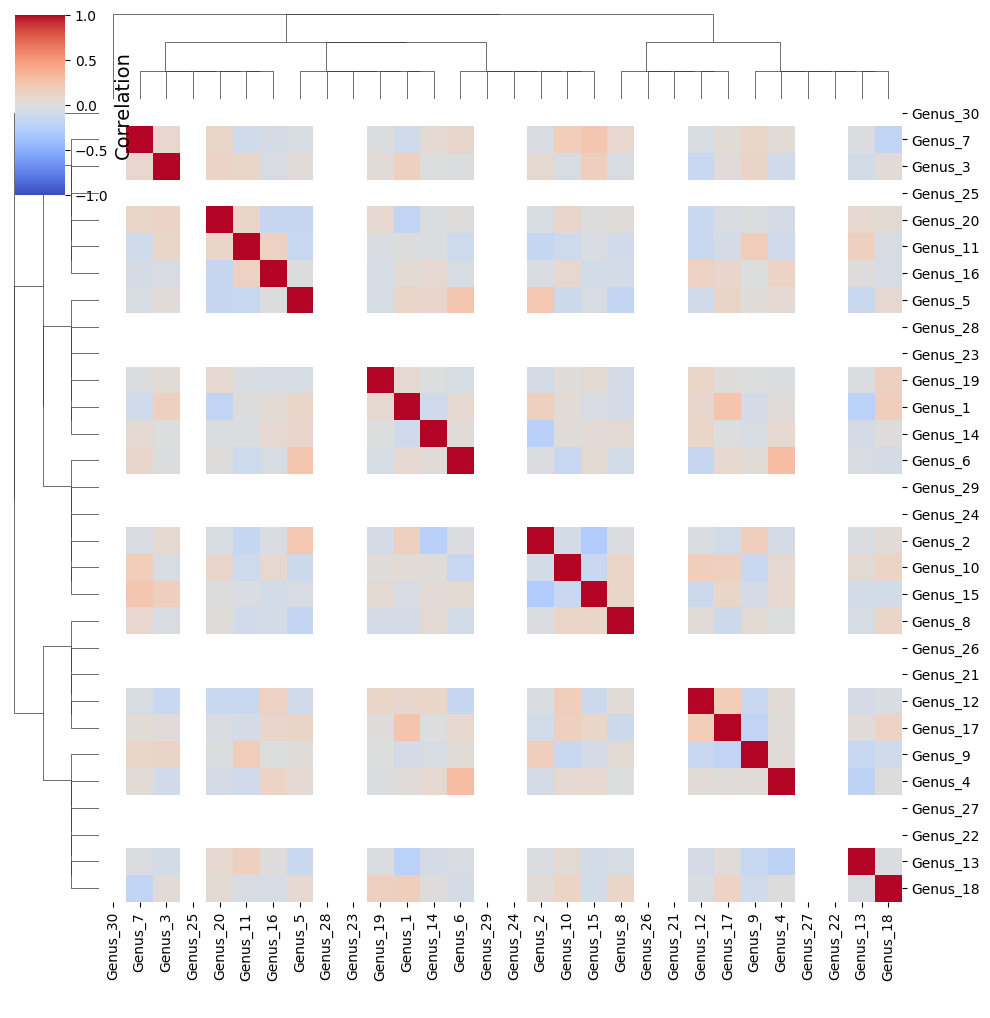

In [ ]:
# 7. Plot with exactly that linkage
g = sns.clustermap(
    df_ordered1,
    cmap='coolwarm',
    vmin = -1,
    vmax = 1,
    row_linkage=linkage_matrix,
    col_linkage=linkage_matrix,
    row_cluster=True,
    col_cluster=True,
    dendrogram_ratio=(0.1, 0.1),
    square=True,
    linewidths=0.0,
    linecolor="gray",
    xticklabels=True,
    yticklabels=True,
    cbar_kws={
          'label': 'Correlation',
          'shrink': 0.7,
          'orientation': 'vertical'
      },
)


g.ax_heatmap.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.15),  # push further down if needed
    ncol=4,
    frameon=False,
    handlelength=2,
    handleheight=2,
    handletextpad=2,
    columnspacing=2.0,
    fontsize=20,
)

# 8. Fix colorbar labels

# Save the figure
g.ax_cbar.set_ylabel("Correlation", fontsize=14)
plt.show()

# Plot of the second correlation

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)
/tmp/ipython-input-68-2000311325.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  g.ax_heatmap.legend(


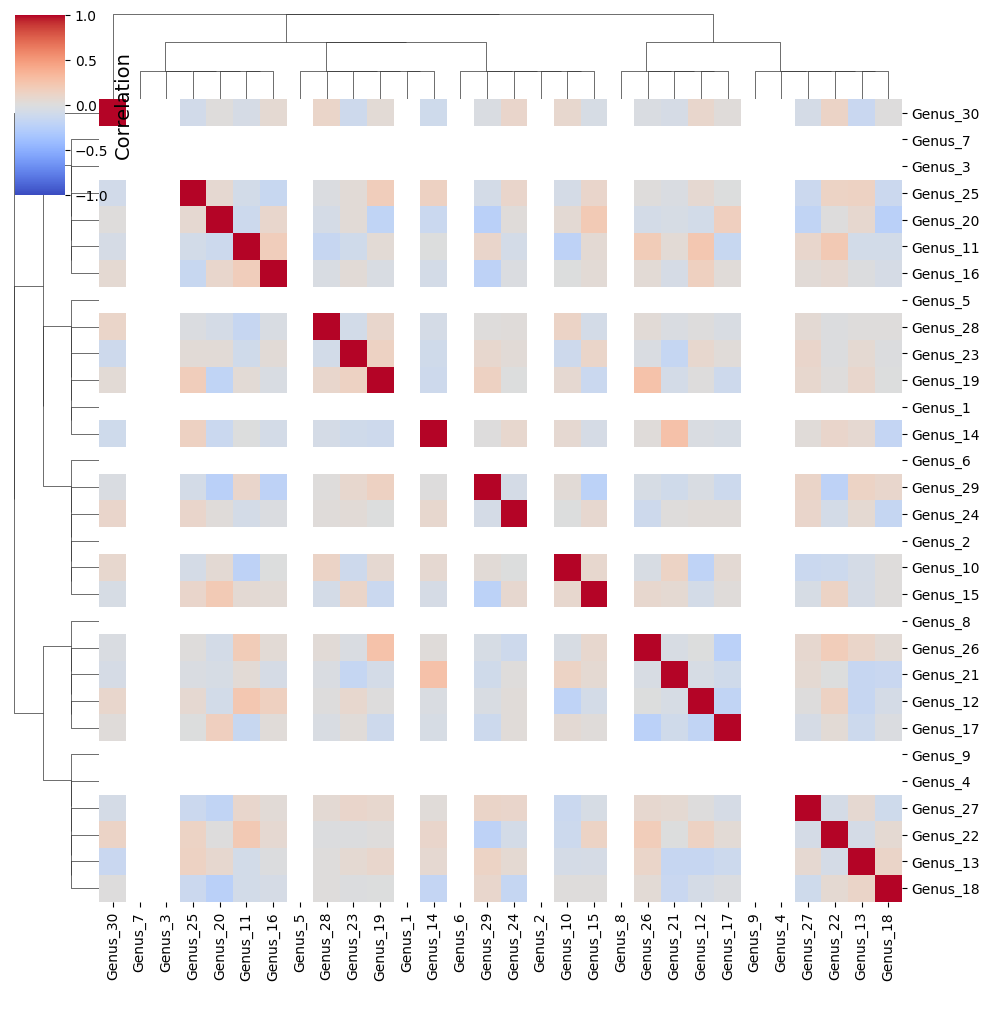

In [ ]:
# 7. Plot with exactly that linkage
g = sns.clustermap(
    df_ordered2,
    cmap='coolwarm',
    vmin = -1,
    vmax = 1,
    row_linkage=linkage_matrix,
    col_linkage=linkage_matrix,
    row_cluster=True,
    col_cluster=True,
    dendrogram_ratio=(0.1, 0.1),
    square=True,
    linewidths=0.0,
    linecolor="gray",
    xticklabels=True,
    yticklabels=True,
    cbar_kws={
          'label': 'Correlation',
          'shrink': 0.7,
          'orientation': 'vertical'
      },
)


g.ax_heatmap.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.15),  # push further down if needed
    ncol=4,
    frameon=False,
    handlelength=2,
    handleheight=2,
    handletextpad=2,
    columnspacing=2.0,
    fontsize=20,
)

# 8. Fix colorbar labels

# Save the figure
g.ax_cbar.set_ylabel("Correlation", fontsize=14)
plt.show()

# 9. End